In [288]:
# pip install qalsadi


In [289]:
import numpy as np
import pandas as pd
import re
import os
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from collections import Counter
from bidi.algorithm import get_display
from wordcloud import WordCloud, ImageColorGenerator
import string
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
nltk.download('punkt')
nltk.download('stopwords')
import qalsadi.lemmatizer as ql


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [290]:
# pip install matplotlib arabic-reshaper python-bidi


In [291]:
train_data_path = '/kaggle/input/arabic-medical-q-and-a-dataset/train.csv'
val_data_path = '/kaggle/input/arabic-medical-q-and-a-dataset/val.csv'
test_data_path = '/kaggle/input/arabic-medical-q-and-a-dataset/test.csv'

train = pd.read_csv(train_data_path)
val = pd.read_csv(val_data_path)
test = pd.read_csv(test_data_path)

In [292]:
print(train.shape)
print(test.shape)
print(val.shape)

(52758, 3)
(17586, 3)
(17586, 3)


# 1.Pre Processing

## 1.1 Missing values removed

In [293]:
train.isnull().sum()


question      0
answer      101
label         0
dtype: int64

In [294]:
test.isnull().sum()

question     0
answer      34
label        0
dtype: int64

In [295]:
qsts_without_answers_train=train[train['answer'].isnull()]
qsts_without_answers_test=test[test['answer'].isnull()]
train.drop(qsts_without_answers_train.index,inplace=True)
test.drop(qsts_without_answers_test.index,inplace=True)


In [296]:
print(train.shape)
print(test.shape)
print(val.shape)

(52657, 3)
(17552, 3)
(17586, 3)


In [297]:
specialty_mapping = {
    "جراحة-عامة": "جراحة عامة",
    "جراحة عامة": "جراحة عامة",
    "جراحة_عامة": "جراحة عامة",
    "جراحه عامة": "جراحة عامة",

    "امراض-الغدد-الصماء": "أمراض الغدد الصماء",
    "أمراض_الغدد_الصماء": "أمراض الغدد الصماء",
    "الغدد-الصماء": "أمراض الغدد الصماء",
    "امراض الغدد الصماء": "أمراض الغدد الصماء",
    "امراض_الغدد_الصماء": "أمراض الغدد الصماء",
    "الغدد الصماء":"أمراض الغدد الصماء",
    "أمراض-الغدد-الصماء":"أمراض الغدد الصماء",


    "الدم":"أمراض الدم",
    "أمراض-الدم":"أمراض الدم",
    "امراض الدم":"أمراض الدم",
    "امراض_الدم":"أمراض الدم",
    "أمراض_الدم":"أمراض الدم",
    "امراض-الدم":"أمراض الدم",


    "ارتفاع-ضغط-الدم":"ارتفاع ضغط الدم",
    "ارتفاع_ضغط_الدم":"ارتفاع ضغط الدم",

    "أمراض-الجهاز-التنفسي":"أمراض الجهاز التنفسي",
    "أمراض-الجهاز-التنفسي":"أمراض الجهاز التنفسي",
    "الجهاز-التنفسي":"أمراض الجهاز التنفسي",
    "أمراض_الجهاز_التنفسي":"أمراض الجهاز التنفسي",
    "امراض الجهاز التنفسي":"أمراض الجهاز التنفسي",
    "امراض_الجهاز_التنفسي":"أمراض الجهاز التنفسي",
    "امراض-الجهاز-التنفسي":"أمراض الجهاز التنفسي",
    "أمراض الجهاز التنفسي":"أمراض الجهاز التنفسي",

    "جراحة-العظام":"جراحة العظام",
    "جراحة_العظام":"جراحة العظام",


    "مرض-السكري":"مرض السكري",
    "مرض_السكري":"مرض السكري",
    "السكري":"مرض السكري",


    "الأورام-الخبيثة-والحميدة":"الأورام الخبيثة والحميدة",
    "الاورام-الخبيثة-والحميدة":"الأورام الخبيثة والحميدة",
    "الاورام_الخبيثة_والحميدة":"الأورام الخبيثة والحميدة",
    "الاورام الخبيثة والحميدة":"الأورام الخبيثة والحميدة",
}

train['label'] = train['label'].map(specialty_mapping).fillna(train['label'])
val['label'] = val['label'].map(specialty_mapping).fillna(val['label'])
test['label'] = test['label'].map(specialty_mapping).fillna(test['label'])

In [298]:
label_counts=train['label'].value_counts().reset_index()
label_counts.columns = ['label', 'count']
label_counts

,label,count
0,الأورام الخبيثة والحميدة,10697
1,جراحة عامة,10531
2,أمراض الغدد الصماء,9404
3,مرض السكري,7078
4,أمراض الجهاز التنفسي,5995
5,ارتفاع ضغط الدم,4170
6,جراحة العظام,2639
7,أمراض الدم,2143


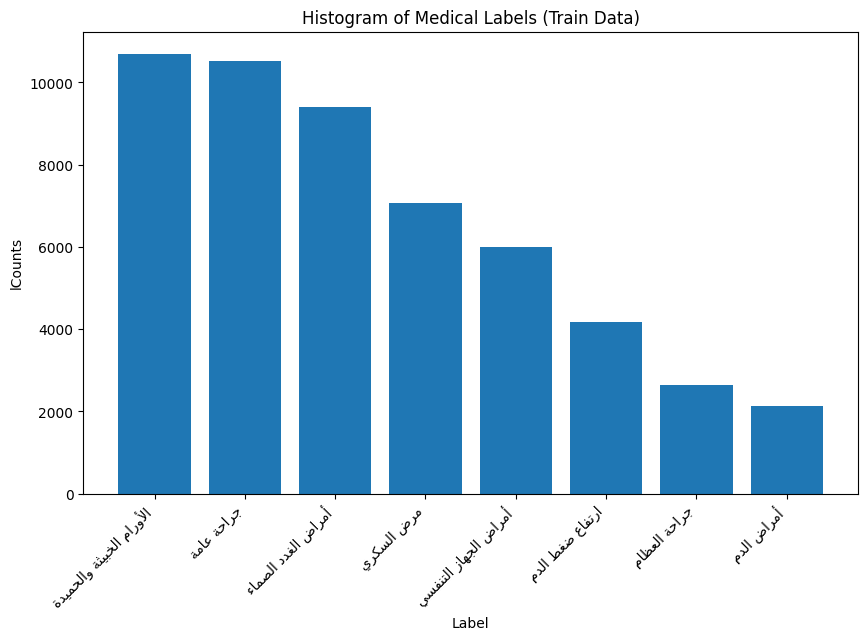

In [299]:
import pandas as pd
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display

# Assuming train is your DataFrame containing the necessary data
# If it's not already loaded, load your train data here
# Example: train = pd.read_csv('your_train_data.csv')

# Calculate label counts
label_counts = train['label'].value_counts().reset_index()
label_counts.columns = ['label', 'count']

# Prepare the data
labels = label_counts['label']
counts = label_counts['count']

# Reshape Arabic labels
reshaped_labels = [get_display(arabic_reshaper.reshape(label)) for label in labels]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the histogram
plt.bar(reshaped_labels, counts)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set labels
plt.xlabel('Label')
plt.ylabel('اCounts')
plt.title('Histogram of Medical Labels (Train Data)')

# Show plot
plt.show()


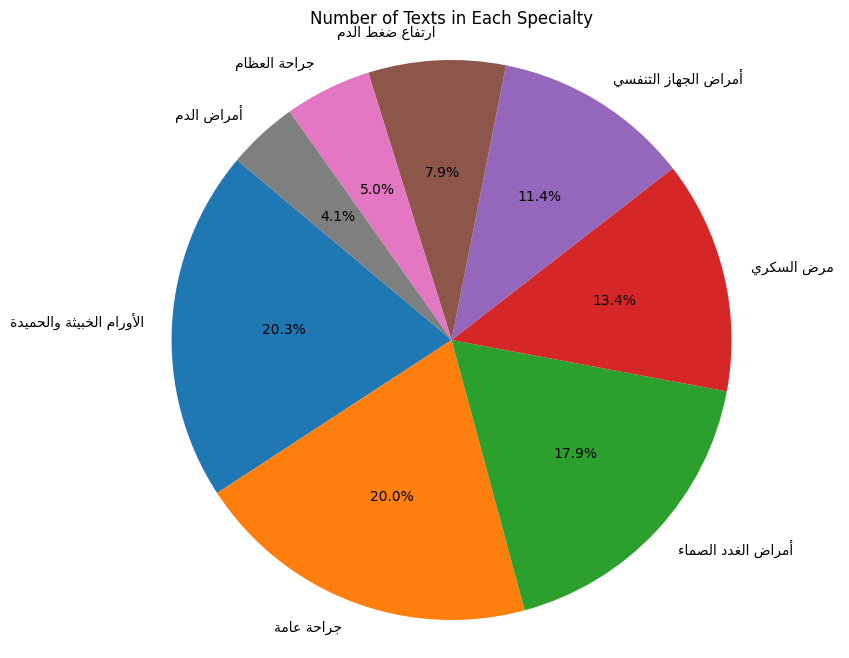

In [300]:
def reshape_labels(labels):
    reshaped_labels = [get_display(arabic_reshaper.reshape(label)) for label in labels]
    return reshaped_labels

specialty_counts = train['label'].value_counts()

reshaped_labels = reshape_labels(specialty_counts.index)

plt.figure(figsize=(10, 8))
plt.pie(specialty_counts, labels=reshaped_labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Number of Texts in Each Specialty')
plt.show()

# Remove names (doctor , time) >>>>>>>>>>>>>>>>>>>>>>>>>>

In [301]:
def clean_text(text):
    text = re.sub(r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}.*$', '', text)
    text = re.sub(r'\d*$', '', text)#To remove the number that exists at the end of each answer
    return text

def clean_question_and_answer_columns(dataset):
    dataset['question']=dataset['question'].str.strip()
    dataset['answer']=dataset['answer'].str.strip()
    dataset['question']=dataset['question'].str.replace('\n',' ')
    dataset['answer']=dataset['answer'].str.replace('\n',' ')
    dataset['answer'] = dataset['answer'].apply(clean_text)
    
clean_question_and_answer_columns(train)
clean_question_and_answer_columns(test)


In [302]:
print(train['answer'][0])

لكل علاج ايجابيته وسلبياته والتي تعتمد على حالة المريض فما قد يناسب احدهم قد لا يناسب الاخر وهذا يحدده الطبيب خلال مراجعة المريض له 1 


# Tokonize if  not bert  >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

In [303]:
# import nltk
# import string
# import re
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# import qalsadi.lemmatizer as ql

# class ArabicTextPreprocessor:

#     def tokenize_text(self, text):
#         # Tokenization
#         tokens = word_tokenize(text)
#         return tokens
    
#     def text_after_preprocess(self, text):
#         tokens = self.tokenize_text(text)
#         return tokens

In [304]:
# preprocessor = ArabicTextPreprocessor()
# val['preprocessed_question'] = val['question'].apply(preprocessor.text_after_preprocess)
# val['preprocessed_answer'] = val['answer'].apply(preprocessor.text_after_preprocess)

# train['preprocessed_question'] = train['question'].apply(preprocessor.text_after_preprocess)
# train['preprocessed_answer'] = train['answer'].apply(preprocessor.text_after_preprocess)

# test['preprocessed_question'] = test['question'].apply(preprocessor.text_after_preprocess)
# test['preprocessed_answer'] = test['answer'].apply(preprocessor.text_after_preprocess)

In [305]:
# train.head()

# Bert >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

In [306]:
def remove_links(text):
    url_pattern = r'https?://\S+|www\.\S+|/\S+-\S+/|\S+-\S+-\S+'
    text = re.sub(url_pattern, '', text)
    return text
def remove_all_numbers(text):
    number_pattern = r'\d+|[٠١٢٣٤٥٦٧٨٩]+'
    return re.sub(number_pattern, '', text)
def remove_date_time(tweet):
    date_time_pattern = r'\b\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\b'
    result = re.sub(date_time_pattern, '', tweet)
    return result.strip()
def keep_arabic_numbers_punctuation(tweet):
    non_arabic_pattern = r'[^\u0600-\u06FF0-9\s\n.,;!?()،:؛؟"\':-]'
    result = re.sub(non_arabic_pattern, '', tweet)
    return result
def remove_punctuation(tweet):
    punctuation_pattern = r'[^\w\s\#]'
    result = re.sub(punctuation_pattern, '', tweet)
    return result
def remove_duplicate_spaces(text):
    space_pattern = r'\s+'
    return re.sub(space_pattern, ' ', text)
def remove_stop_words(text):
    arabic_stopwords = set(stopwords.words('arabic'))
    custom_stopwords = [
    'اقرأ', 'المزيد', 'أرجو', 'الرد', 'و', 'في', 'على', 'من', 'رقم', 
    'هي', 'هو', 'أنا', '?', 'ما', 'وما', 'وهل', 'السلام عليكم', 'وشكرا', 
    'انا', 'فهل', 'وعليكم', 'هل', '؟', 'رقم', 'رقم:رقم:رقم', 
     'عليكم', 'وانا', 'الى', 'انا', 'او', 
    'السلام', 'عندي', 'ان', 'فى'
    ]# Add custom stopwords to the set
    arabic_stopwords.update(custom_stopwords)
    words = text.split()
    filtered_words = [word for word in words if word not in arabic_stopwords]
    return ' '.join(filtered_words)
def clearData(text) :
    text = remove_links(text)
    text = remove_all_numbers(text)
    text = remove_duplicate_spaces(text)
    text = remove_stop_words(text)
    return text

In [307]:
# arabic_stopwords = set(stopwords.words('arabic')) 
# custom_stopwords = [
#     'اقرأ', 'المزيد', 'أرجو', 'الرد', 'و', 'في', 'على', 'من', 'رقم', 
#     'هي', 'هو', 'أنا', '?', 'ما', 'وما', 'وهل', 'السلام عليكم', 'وشكرا', 
#     'انا', 'فهل', 'وعليكم', 'هل', '؟', 'رقم', 'رقم:رقم:رقم', 
#      'عليكم', 'وانا', 'الى', 'انا', 'او', 
#     'السلام', 'عندي', 'ان', 'فى'
# ]# Add custom stopwords to the set
# arabic_stopwords.update(custom_stopwords)
# print(arabic_stopwords)

In [308]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [309]:

# Preprocess data: Combine question and answer
train['text'] = train['question'] + " " + train['answer']
test['text'] = test['question'] + " " + test['answer']

train['text'] = train['text'].apply(lambda x: clearData(x))
test['text'] = test['text'].apply(lambda x: clearData(x))


In [310]:
train.head()

,question,answer,label,text
0,ما هي مميزات و عيوب الدواء جلوكوفانس 500 5 و ا...,لكل علاج ايجابيته وسلبياته والتي تعتمد على حال...,أمراض الدم,مميزات عيوب الدواء جلوكوفانس ايضا الأنسولين مك...
1,اليك نتيجة تحليل هرمونات الغدة الدرقية علما با...,نعم. يجب تخفيض الجرعة، الا اذا كان سبب استئصال...,الأورام الخبيثة والحميدة,اليك نتيجة تحليل هرمونات الغدة الدرقية علما با...
2,حلول منزلية لأعراض ارتفاع ضغط الدم,يفضل عدم الاستغناء عن العلاج الدوائي لمرضى الض...,جراحة عامة,حلول منزلية لأعراض ارتفاع ضغط الدم يفضل عدم ال...
3,عملت عملية دوالي الساقين قسطرة الليزر من شهر و...,راجع طبيبك من اجري الجراحه افضل من يجيب لانه ش...,أمراض الجهاز التنفسي,عملت عملية دوالي الساقين قسطرة الليزر شهر وعند...
4,ما حقيقة ان تمرين العضلة النعلية يخفض السكر با...,إذا قصدت تدليك العضلة فهذا كلام غير صحيح . ولك...,مرض السكري,حقيقة تمرين العضلة النعلية يخفض السكر بالدم؟؟ ...


In [311]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch


from transformers import AutoTokenizer, AutoModel
model_name= 'aubmindlab/bert-base-arabertv02'  
tokenizer = AutoTokenizer.from_pretrained(model_name,model_max_length=100)

In [312]:
# Tokenize the inputs
train_encodings = tokenizer(train['text'].tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test['text'].tolist(), truncation=True, padding=True)

# Convert labels to tensors
# Here assuming that the labels are categorical and need to be converted to integer encodings
label2id = {label: idx for idx, label in enumerate(train['label'].unique())}

id2label = {idx: label for label, idx in label2id.items()}

train_labels = torch.tensor(train['label'].map(label2id).values)
test_labels = torch.tensor(test['label'].map(label2id).values)



# Create a custom dataset class
class QADataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item
    
    def __len__(self):
        return len(self.labels)



In [313]:
from transformers import AutoTokenizer, AutoModel

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [314]:
model = BertForSequenceClassification.from_pretrained(model_name,num_labels=8,
                                                      output_attentions=False,output_hidden_states=True)  #false


# model=AutoModel.from_pretrained(model_name,output_hidden_states=True,num_labels=8)

model.to(DEVICE)
model.train()
optim = torch.optim.Adam(model.parameters(), lr=5e-5)
NUM_EPOCHS = 4

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [315]:
train_dataset = QADataset(train_encodings, train_labels)
test_dataset = QADataset(test_encodings, test_labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [316]:
def compute_accuracy(model, data_loader, device):
    with torch.no_grad():
        correct_pred, num_examples = 0, 0
        
        for batch_idx, batch in enumerate(data_loader):
        
        ### Prepare data
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs['logits']
            predicted_labels = torch.argmax(logits, 1)
            num_examples += labels.size(0)
            correct_pred += (predicted_labels == labels).sum()
        
        return correct_pred.float()/num_examples * 100

In [317]:
# for epoch in range(NUM_EPOCHS):
    
#     model.train()
    
#     for batch_idx, batch in enumerate(train_loader):
        
#         ### Prepare data
#         input_ids = batch['input_ids'].to(DEVICE)
#         attention_mask = batch['attention_mask'].to(DEVICE)
#         labels = batch['labels'].to(DEVICE)

#         ### Forward
#         outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#         loss, logits = outputs['loss'], outputs['logits']
        
#         ### Backward
#         optim.zero_grad()
#         loss.backward()
#         optim.step()
        
#         ### Logging
#         if not batch_idx % 250:
#             print (f'Epoch: {epoch+1:04d}/{NUM_EPOCHS:04d} | '
#                    f'Batch {batch_idx:04d}/{len(train_loader):04d} | '
#                    f'Loss: {loss:.4f}')
            
#     model.eval()

#     with torch.set_grad_enabled(False):
#         print(f'Training accuracy: '
#               f'{compute_accuracy(model, train_loader, DEVICE):.2f}%'
#               f'\nValid accuracy: '
#               f'{compute_accuracy(model, test_loader, DEVICE):.2f}%')

In [318]:
save_directory = './saved_models'
os.makedirs(save_directory, exist_ok=True)
model_save_path = os.path.join(save_directory, 'bert_final_model.pt')
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')


model_save_path = './saved_models/bert_final_model.pt'
model.load_state_dict(torch.load(model_save_path))

Model saved to ./saved_models/bert_final_model.pt


<All keys matched successfully>

In [319]:
# Save tokenizer
tokenizer.save_pretrained(save_directory)
print(f'Tokenizer saved to {save_directory}')

Tokenizer saved to ./saved_models


In [320]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs['logits']
            preds = torch.argmax(logits, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    return accuracy, precision, recall, f1

for epoch in range(2):
    
    model.train()
    
    for batch_idx, batch in enumerate(train_loader):
        
        ### Prepare data
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        ### Forward
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs['loss'], outputs['logits']
        
        ### Backward
        optim.zero_grad()
        loss.backward()
        optim.step()
               
    val_accuracy, val_precision, val_recall, val_f1 = compute_metrics(model, test_loader, DEVICE)
    
    print(f'Validation Accuracy: {val_accuracy:.4f} | '
          f'Precision: {val_precision:.4f} | '
          f'Recall: {val_recall:.4f} | '
          f'F1 Score: {val_f1:.4f}')
    print('\n\n')


Validation Accuracy: 0.6924 | Precision: 0.6898 | Recall: 0.6805 | F1 Score: 0.6840



Validation Accuracy: 0.6969 | Precision: 0.6929 | Recall: 0.6914 | F1 Score: 0.6911





In [321]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

def preprocess_text(text, tokenizer):
    inputs = tokenizer(
        text,
        return_tensors='pt',
        max_length=100,  # Adjust according to your model's requirements
        truncation=True,
        padding=True
    )
    return inputs

def predict(text, model, tokenizer, device):
    model.eval()
    inputs = preprocess_text(text, tokenizer)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.softmax(logits, dim=-1)
        predicted_class_idx = torch.argmax(predictions, dim=-1).item()
        predicted_class = id2label[predicted_class_idx]
        prediction_scores = predictions[0].cpu().numpy()
    
    label_scores = {id2label[idx]: score for idx, score in enumerate(prediction_scores)}

    return predicted_class, label_scores

# Make a prediction
text = input("Please enter the text for prediction: ")
predicted_class, prediction_scores = predict(text, model, tokenizer, DEVICE)


print(f"Predicted class: {predicted_class}")
for label, score in prediction_scores.items():
    print(f"{label}: {score:.4f}")

Please enter the text for prediction:  رجلي احتمال مكسورة


Predicted class: جراحة العظام
أمراض الدم: 0.0086
الأورام الخبيثة والحميدة: 0.0485
جراحة عامة: 0.0741
أمراض الجهاز التنفسي: 0.0213
مرض السكري: 0.0147
أمراض الغدد الصماء: 0.0319
ارتفاع ضغط الدم: 0.0149
جراحة العظام: 0.7860


In [322]:
# Make a prediction
text = input("Please enter the text for prediction: ")
predicted_class, prediction_scores = predict(text, model, tokenizer, DEVICE)


print(f"Predicted class: {predicted_class}")
for label, score in prediction_scores.items():
    print(f"{label}: {score:.4f}")

Please enter the text for prediction:  دخان


Predicted class: أمراض الجهاز التنفسي
أمراض الدم: 0.0186
الأورام الخبيثة والحميدة: 0.0913
جراحة عامة: 0.0528
أمراض الجهاز التنفسي: 0.6527
مرض السكري: 0.0952
أمراض الغدد الصماء: 0.0500
ارتفاع ضغط الدم: 0.0303
جراحة العظام: 0.0092


In [323]:
# Make a prediction
text = input("Please enter the text for prediction: ")
predicted_class, prediction_scores = predict(text, model, tokenizer, DEVICE)


print(f"Predicted class: {predicted_class}")
for label, score in prediction_scores.items():
    print(f"{label}: {score:.4f}")

Please enter the text for prediction:  بنكرياسي راح


Predicted class: الأورام الخبيثة والحميدة
أمراض الدم: 0.0091
الأورام الخبيثة والحميدة: 0.7144
جراحة عامة: 0.0811
أمراض الجهاز التنفسي: 0.0283
مرض السكري: 0.0589
أمراض الغدد الصماء: 0.0734
ارتفاع ضغط الدم: 0.0234
جراحة العظام: 0.0114


In [324]:
# Make a prediction
text = input("Please enter the text for prediction: ")
predicted_class, prediction_scores = predict(text, model, tokenizer, DEVICE)


print(f"Predicted class: {predicted_class}")
for label, score in prediction_scores.items():
    print(f"{label}: {score:.4f}")

Please enter the text for prediction:  عندي مشكلة بالبنكرياس


Predicted class: الأورام الخبيثة والحميدة
أمراض الدم: 0.0089
الأورام الخبيثة والحميدة: 0.5804
جراحة عامة: 0.0611
أمراض الجهاز التنفسي: 0.0386
مرض السكري: 0.0470
أمراض الغدد الصماء: 0.2264
ارتفاع ضغط الدم: 0.0263
جراحة العظام: 0.0113


In [325]:
for idx, label in id2label.items():
    print(f"Index: {idx} - Label: {label}")

Index: 0 - Label: أمراض الدم
Index: 1 - Label: الأورام الخبيثة والحميدة
Index: 2 - Label: جراحة عامة
Index: 3 - Label: أمراض الجهاز التنفسي
Index: 4 - Label: مرض السكري
Index: 5 - Label: أمراض الغدد الصماء
Index: 6 - Label: ارتفاع ضغط الدم
Index: 7 - Label: جراحة العظام
